# Deep learning
---------------------------

This example shows how to use ATOM to train and validate a Convolutional Neural Network implemented with [Keras](https://keras.io/).

Import the MNIST dataset from [keras.datasets](https://keras.io/api/datasets/mnist/). This is a well known image dataset whose goal is to classify handwritten digits.

## Load the data

In [1]:
# Disable annoying tf warnings
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

# Import standard packages
from atom import ATOMClassifier, ATOMModel
from skopt.space.space import Integer, Categorical

# Keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# Create the convolutional neural network
def neural_network():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(28, 28, 1)))
    model.add(Conv2D(64, kernel_size=3, activation="relu"))
    model.add(Flatten())
    model.add(Dense(10, activation="softmax"))
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


# Since ATOM uses sklearn's API, use Keras' wrapper
model = KerasClassifier(neural_network, epochs=1, batch_size=512, verbose=0)

# Convert the model to an ATOM model
model = ATOMModel(model, acronym="NN", fullname="Neural network")

In [3]:
# Download the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
# Reshape data to fit model
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

data = (X_train, y_train), (X_test, y_test)

## Run the pipeline

In [5]:
atom = ATOMClassifier(*data, n_rows=0.1, n_jobs=6, warnings=False, verbose=2)

<< ================== ATOM ================== >>
Algorithm task: multiclass classification.
Parallel processing with 6 cores.

Dataset stats ====================== >>
Shape: (7000, (28, 28, 1), 2)
---------------------------------------
Train set size: 6000
Test set size: 1000
---------------------------------------
|    | dataset   | train     | test      |
|---:|:----------|:----------|:----------|
|  0 | 661 (1.0) | 566 (1.0) | 95 (1.1)  |
|  1 | 739 (1.1) | 649 (1.2) | 90 (1.0)  |
|  2 | 690 (1.1) | 586 (1.1) | 104 (1.2) |
|  3 | 720 (1.1) | 620 (1.1) | 100 (1.2) |
|  4 | 704 (1.1) | 589 (1.1) | 115 (1.3) |
|  5 | 643 (1.0) | 549 (1.0) | 94 (1.1)  |
|  6 | 712 (1.1) | 626 (1.1) | 86 (1.0)  |
|  7 | 733 (1.1) | 622 (1.1) | 111 (1.3) |
|  8 | 704 (1.1) | 602 (1.1) | 102 (1.2) |
|  9 | 694 (1.1) | 591 (1.1) | 103 (1.2) |



In [6]:
# When the input data has more than 2 dimensions, ATOM creates a 
# dataset with just one column of shape (n_samples, shape_sample)
atom.head()

                            Multidimensional feature  Target
0  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       5
1  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       8
2  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       8
3  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       3
4  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       9


In [7]:
# Every row in the column contains the data of one image
print(f"Shape of one image: {atom.iloc[0, 0].shape}")
print(f"atom's shape (n_rows, (shape_image), n_cols): {atom.shape}")

Shape of one image: (28, 28, 1)
atom's shape (n_rows, (shape_image), n_cols): (7000, (28, 28, 1), 2)


In [8]:
# Like any other model, we can define custom dimensions for the bayesian optimization
dim = [Integer(1, 3, name="epochs"), Categorical([32, 64, 128, 256], name="batch_size")]

atom.run(model, metric="f1_weighted", n_calls=5, bo_params={"dimensions": dim, "cv": 1, "max_time": 120})


Training ===================================== >>
Models: NN
Metric: f1_weighted


Running BO for Neural network...
Initial point 1 ---------------------------------
Parameters --> {'epochs': 3, 'batch_size': 256}
Evaluation --> f1_weighted: 0.9416  Best f1_weighted: 0.9416
Time iteration: 21.756s   Total time: 21.760s
Initial point 2 ---------------------------------
Parameters --> {'epochs': 2, 'batch_size': 256}
Evaluation --> f1_weighted: 0.9351  Best f1_weighted: 0.9416
Time iteration: 8.107s   Total time: 29.995s
Initial point 3 ---------------------------------
Parameters --> {'epochs': 1, 'batch_size': 128}
Evaluation --> f1_weighted: 0.9238  Best f1_weighted: 0.9416
Time iteration: 4.647s   Total time: 34.677s
Initial point 4 ---------------------------------
Parameters --> {'epochs': 2, 'batch_size': 128}
Evaluation --> f1_weighted: 0.9442  Best f1_weighted: 0.9442
Time iteration: 8.606s   Total time: 43.311s
Initial point 5 ---------------------------------
Parameters --> {

## Analyze the results

In [9]:
# Use the prediction methods like any other model
atom.nn.predict_proba(X_train)

array([[3.5266876e-10, 2.7054303e-09, 6.5099565e-11, ..., 2.0648958e-08,
        5.2870408e-10, 8.0803983e-07],
       [1.0000000e+00, 1.0826281e-15, 3.2899516e-10, ..., 3.7689074e-13,
        4.7216215e-12, 1.0242848e-11],
       [4.9486027e-12, 3.2953235e-08, 1.6609141e-07, ..., 4.5303813e-07,
        1.0848631e-06, 9.5844080e-05],
       ...,
       [8.7318136e-15, 1.5246022e-12, 5.7787917e-18, ..., 1.6206396e-18,
        2.9980916e-09, 1.0435880e-09],
       [1.7884300e-09, 5.5821411e-18, 2.0973881e-10, ..., 4.0482449e-14,
        2.3880355e-13, 4.3091268e-15],
       [6.0590587e-08, 2.2131283e-09, 5.9565604e-08, ..., 3.5685554e-07,
        9.9999332e-01, 8.8240580e-07]], dtype=float32)

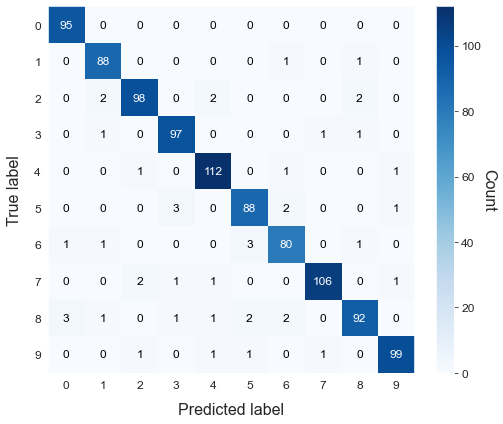

In [10]:
# Or make plots...
atom.nn.plot_confusion_matrix()